## <font color='blue'>Using `Dask`, `Xarray`, and `Rasterio` to process satellite imagery</font>

> Singularity environment located @ **/export/home/graesserj/singularity/python3_env.sif**
---

In [ ]:
# !export PATH=/opt/sw/fw/rsc/Spack/installHome/linux-sles12-x86_64/gcc-7/graphviz-2.40.1-huzrbgjwzk7mj3aqcphz22jpzrvv34yl/bin:$PATH

In [1]:
# https://github.com/pydata/xarray/issues/2560
import netCDF4
import h5netcdf

In [2]:
import sys
sys.path = [p for p in sys.path if 'home' not in p]

In [3]:
%load_ext watermark

In [4]:
%watermark -a "Dask/Xarray session" -d -v -m -p geowombat,numpy,geopandas,xarray,dask,distributed,rasterio,joblib -g

Dask/Xarray session 2019-09-25 

CPython 3.6.8
IPython 7.5.0

geowombat 0.1.0
numpy 1.16.4
geopandas 0.5.1
xarray 0.13.0
dask 2.4.0
distributed 2.4.0
rasterio 1.0.28
joblib 0.13.2

compiler   : GCC 8.0.1 20180414 (experimental) [trunk revision 259383
system     : Linux
release    : 4.12.14-95.24-default
machine    : x86_64
processor  : x86_64
CPU cores  : 72
interpreter: 64bit
Git hash   :


In [5]:
# Add to any script and GeoWombat functionality will 
# be appended to Xarray Datasets or DataArrays
import geowombat as gw

In [6]:
import os
import fnmatch
import datetime
import time

In [7]:
import numpy as np
import pandas as pd
import geopandas as gpd

import xarray as xr

import dask
import dask.array as da

# Distributed task scheduling on the cluster
from dask.distributed import Client, LocalCluster
from dask_jobqueue import PBSCluster

import joblib

import matplotlib.pyplot as plt

---

## <font color='green'>Functions</font>

In [8]:
def date_to_datetime(date_str):
    
    """
    Helper function to convert a date to a `datetime` object
    """

    y1 = date_str[1:5]
    m1 = date_str[5:7]
    y2 = date_str[7:11]
    m2 = date_str[11:]
    
    dt1 = datetime.datetime.strptime('{}-{}-01'.format(y1, m1), '%Y-%m-%d')
    dt2 = datetime.datetime.strptime('{}-{}-01'.format(y2, m2), '%Y-%m-%d')
    
    return dt1 + (dt2 - dt1)

---
# <font color='green'>`Dask` basics</font>

> ## Easily scale and parrallelize workflows
> ### Developed with `NumPy`, `Pandas`, and `Scikit-learn`

In [9]:
import dask
import dask.array as da

### `dask.delayed`

In [10]:
a = np.random.random((100, 100))
b = np.random.random((100, 100))

### Add the `dask.delayed` decorator to create a "lazy" function

In [ ]:
@dask.delayed
def add_delayed(array1, array2):
    return array1 + array2

In [ ]:
array_sum = add_delayed(a, b)

### No computation happens

In [ ]:
array_sum

### The function is lazy, but not parallelized

In [ ]:
# array_sum.visualize()

### Run `compute` to get the results

In [ ]:
array_sum.compute()

### Add `NumPy` arrays in parallel

In [ ]:
def add_iter(*args):    
    result = list()
    for i in range(0, len(args), 2):
        array_sum = add_delayed(args[i], args[i+1])  # <-- lazy function
        result.append(array_sum)
    return np.array(result).sum(axis=0)              # <-- return the sum over all arrays

In [ ]:
c = np.random.random((100, 100))
d = np.random.random((100, 100))
e = np.random.random((100, 100))
f = np.random.random((100, 100))

In [ ]:
array_sum = add_iter(a, b, c, d, e, f)

In [ ]:
np.allclose(array_sum.compute(), a+b+c+d+e+f)

In [ ]:
array_sum

In [ ]:
# array_sum.visualize()

### Add `dask` arrays in parallel

In [ ]:
# dask.array (`da`) replaces numpy
a = da.random.random((1000, 1000), chunks=(500, 500))
b = da.random.random((1000, 1000), chunks=(500, 500))
c = da.random.random((1000, 1000), chunks=(500, 500))
d = da.random.random((1000, 1000), chunks=(500, 500))
e = da.random.random((1000, 1000), chunks=(500, 500))
f = da.random.random((1000, 1000), chunks=(500, 500))

In [ ]:
result = a + b + c + d + e + f

In [ ]:
result

### Now the operations are parallelized over the arrays and chunks

In [ ]:
# result.visualize()

## `Dask.dataframe`

In [ ]:
import dask.dataframe as dd

### Concatenate a directory of files

In [ ]:
# df = dd.read_csv('*.csv')

---
# <font color='green'>`Xarray` basics</font>

> ## Named n-dimensional arrays
> ### `Pandas` + `NumPy` + `Dask`
> ### Tailored toward NetCDF file format, but `Rasterio` functionality exists

In [ ]:
import xarray as xr

### `DataArrays` are named n-dimensional arrays (`NumPy` or `Dask`)

In [ ]:
data = xr.DataArray(np.random.random((2, 5)),       # <-- 2d NumPy array
                    dims=('y', 'x'),                # <-- coordinate names
                    coords={'y': [0, 1],            # <-- y coordinate labels
                            'x': [0, 1, 2, 3, 4]})  # <-- x coordinate labels

In [ ]:
data

### Easily add dimensions

In [ ]:
data = xr.DataArray(np.random.random((2, 2, 5)),        # <-- 3d NumPy array
                    dims=('z', 'y', 'x'),               # <-- coordinate names
                    coords={'z': ['layer1', 'layer2'],  # <-- z coordinate labels
                            'y': [0, 1],                # <-- y coordinate labels
                            'x': [0, 1, 2, 3, 4]})      # <-- x coordinate labels

In [ ]:
data

### The underlying data can be accessed with the `data` attribute

In [ ]:
data.data

### Replace `NumPy` arrays with `Dask` arrays

In [ ]:
data = xr.DataArray(da.random.random((2, 2, 5)),        # <-- 3d Dask array
                    dims=('z', 'y', 'x'),               # <-- coordinate names
                    coords={'z': ['layer1', 'layer2'],  # <-- z coordinate labels
                            'y': [0, 1],                # <-- y coordinate labels
                            'x': [0, 1, 2, 3, 4]})      # <-- x coordinate labels

In [ ]:
data

### Get `Dask` data

In [ ]:
# All the same result
# data.values
# data.data.compute()
# data.load().data

### `Pandas`-style indexing with named coordinates

In [ ]:
data.sel(z='layer1')

In [ ]:
data.sel(z='layer1', y=0)

### `Datasets` are dict-like containers of `DataArrays` (similar to a `Pandas` `DataFrame`)

In [ ]:
bands_data = da.random.random((2, 2, 5))                  # <-- 3d Dask array

inputs = {'bands': (['layers', 'y', 'x'], bands_data)}    # <-- Specify the variable name and coordinates

coords = {'layers': ['layer1', 'layer2'],                 # <-- Dictionary of all possible coordinates
          'y': [0, 1],
          'x': [0, 1, 2, 3, 4]}

ds = xr.Dataset(inputs, coords=coords)

In [ ]:
ds

### Add multiple variables

In [ ]:
bands_data = da.random.random((2, 2, 5))                   # <-- 3d Dask array
ts_data = da.random.random((4, 2, 2, 5))                   # <-- 4d Dask array
mask_data = da.random.random((2, 5))                       # <-- 2d Dask array

inputs = {'bands': (['layers', 'y', 'x'], bands_data),     # <-- Specify the variable name and coordinates
          'time series': (['time', 'layers', 'y', 'x'], ts_data),
          'mask': (['y', 'x'], mask_data)}

coords = {'layers': ['layer1', 'layer2'],                  # <-- Dictionary of all possible coordinates
          'time': ['d1', 'd2', 'd3', 'd4'],
          'y': [0, 1],
          'x': [0, 1, 2, 3, 4]}

attrs = {'crs': 'Data CRS', 'transform': 'Data transform'}

ds = xr.Dataset(inputs, coords=coords, attrs=attrs)

In [ ]:
ds

### Access `DataArray` variables like a dictionary

In [ ]:
ds['time series']

---
# <font color='green'>GeoWombat</font>

> ### Specialized geo-functions with `Dask`, `Xarray`, and `Rasterio`
> ### Current development home is https://github.com/jgrss/geowombat

### Importing `GeoWombat` in a script will automatically append its functionality to any `Xarray` `Dataset` or `DataArray`

In [11]:
import geowombat as gw

### Loading data from a raster file

In [12]:
frac_dir = '/scratch/rsc5/seasonalCoverMosaics/qld'
sr_dir = '/scratch/rsc8/seasonalReflectance'

In [13]:
# Statewide mosaic of Landsat fractional cover for a single date
frac = os.path.join(frac_dir, 'lztmre_qld_m201903201905_dima2.tif')

In [14]:
# Statewide mosaic of Landsat surface reflectance for a single date
sr = os.path.join(sr_dir, 'lztmre_qld_m201006201008_dbia2.tif')

### Open the statewide fractional cover raster

In [15]:
# Open fractional cover as an `Xarray.DataArray`
with gw.open(frac, chunks=(1, 512, 512)) as ds:
    print(ds)

<xarray.DataArray (band: 4, y: 85092, x: 63186)>
dask.array<open_rasterio-48645b72d761155bf2cf4e2fa968252d<this-array>, shape=(4, 85092, 63186), dtype=uint8, chunksize=(1, 512, 512), chunktype=numpy.ndarray>
Coordinates:
  * band     (band) int64 1 2 3 4
  * y        (y) float64 -8.554e+05 -8.555e+05 ... -3.408e+06 -3.408e+06
  * x        (x) float64 4.042e+05 4.042e+05 4.043e+05 ... 2.3e+06 2.3e+06
Attributes:
    transform:      (30.0, 0.0, 404205.0, 0.0, -30.0, -855425.0)
    crs:            +proj=aea +lat_1=-18 +lat_2=-36 +lat_0=0 +lon_0=132 +x_0=...
    res:            (30.0, 30.0)
    is_tiled:       1
    nodatavals:     (0.0, 0.0, 0.0, 0.0)
    scales:         (1.0, 1.0, 1.0, 1.0)
    offsets:        (0.0, 0.0, 0.0, 0.0)
    AREA_OR_POINT:  Area


In [16]:
# Same as ...
# with xr.open_rasterio(frac, chunks=(1, 512, 512)) as ds:
#     print(ds)

In [17]:
# Open surface reflectance as an `Xarray.DataArray`
with gw.open(sr, chunks=(1, 512, 512)) as ds:
    print(ds)

<xarray.DataArray (band: 6, y: 85092, x: 63186)>
dask.array<open_rasterio-ecb1b08dad9855d7f5c4a853ed4dfc98<this-array>, shape=(6, 85092, 63186), dtype=int16, chunksize=(1, 512, 512), chunktype=numpy.ndarray>
Coordinates:
  * band     (band) int64 1 2 3 4 5 6
  * y        (y) float64 -8.554e+05 -8.555e+05 ... -3.408e+06 -3.408e+06
  * x        (x) float64 4.042e+05 4.042e+05 4.043e+05 ... 2.3e+06 2.3e+06
Attributes:
    transform:      (30.0, 0.0, 404205.0, 0.0, -30.0, -855425.0)
    crs:            +proj=aea +lat_1=-18 +lat_2=-36 +lat_0=0 +lon_0=132 +x_0=...
    res:            (30.0, 30.0)
    is_tiled:       1
    nodatavals:     (32767.0, 32767.0, 32767.0, 32767.0, 32767.0, 32767.0)
    scales:         (1.0, 1.0, 1.0, 1.0, 1.0, 1.0)
    offsets:        (0.0, 0.0, 0.0, 0.0, 0.0, 0.0)
    AREA_OR_POINT:  Area


---

In [ ]:
# Open as an `Xarray.Dataset`
with gw.open(frac, xarray_return='dataset', chunks=(1, 512, 512)) as ds:
    print(ds)

In [ ]:
# Open fractional cover as an `Xarray.Dataset` and specify band names
with gw.open(frac, 
             xarray_return='dataset', 
             band_names=['non-green', 'green', 'bare', 'error']) as ds:
    
    print(ds)

In [ ]:
# Same as ...
# with xr.open_rasterio(frac, chunks=(1, 2048, 2048)) as data_array:
# 
#     ds = xr.Dataset({'bands': (['component', 'y', 'x'], data_array.data)},
#                     coords={'component': ['non-green', 'green', 'bare', 'error'],
#                             'y': ('y', data_array.y),
#                             'x': ('x', data_array.x)}, 
#                     attrs=data_array.attrs)

In [ ]:
# Open surface reflectance as an `Xarray.Dataset` and specify band names
with gw.open(sr, 
             xarray_return='dataset', 
             band_names=['blue', 'green', 'red', 'nir', 'swir1', 'swir2']) as ds:
    
    print(ds)

---

In [ ]:
# Open as `rasterio` object
with gw.open(frac, use='rasterio') as src:
    print(src)

In [ ]:
src

In [ ]:
# Same as ...
# with rasterio.open(frac) as src:
#     print(src)

### Open NetCDF files

In [56]:
nc_file = '/scratch/rsc4/graesser/datasets/netcdf_temp/oli_tirs_2019_0124.nc'

In [ ]:
with gw.open(nc_file,
             chunks={'wavelength': 1,
                     'y': 2000,
                     'x': 2000}) as ds:
    print(ds)

### is the same as ...

In [ ]:
# with xr.open_dataset(nc_file,
#                      chunks={'wavelength': 1,
#                              'y': 2000,
#                              'x': 2000}) as ds:
#     print(ds)

### Data accessors to develop on top of `Xarray` using `GeoWombat`

In [ ]:
# Every Xarray Dataset or DataArray will have the `gw` method appended
with gw.open(frac) as ds:
    print(ds.gw)

## <font color='green'>Stack multiple images</font>

In [44]:
fn_list = sorted(fnmatch.filter(os.listdir(frac_dir), '*.tif'))
fn_list = [os.path.join(frac_dir, fn) for fn in fn_list]

In [45]:
datetime_series = [date_to_datetime(fn.split('_')[2]) for fn in fn_list]

In [46]:
datetime_series[:3]

[datetime.datetime(1988, 2, 1, 0, 0),
 datetime.datetime(1988, 5, 1, 0, 0),
 datetime.datetime(1988, 8, 1, 0, 0)]

### Open a list of images

In [ ]:
with gw.open(fn_list[:10],                                       # <-- only load 10 images for illustration
             xarray_return='dataset', 
             band_names=['non-green', 'green', 'bare', 'error'], 
             dates=datetime_series[:10]) as ds:                  # <-- only load 10 images for illustration
    
    print(ds)

## <font color='green'>Extract data within an area or at points of interest</font>

In [18]:
# 10,000 random points stored in WGS84 lat/lon
vector_point = '/scratch/rsc4/graesser/datasets/crf_eval/random_10000.gpkg'

df_point = gpd.read_file(vector_point)

print('Shape:', df_point.shape, '\n')
print(df_point.head(3))

Shape: (10000, 2) 

   id                                      geometry
0   0  POINT (145.5948574046208 -21.39515878541751)
1   1  POINT (147.1733690250191 -26.37830076067615)
2   2  POINT (147.4398987988097 -21.23421550784088)


In [19]:
# 10,000 random points stored in WGS84 lat/lon
vector_poly = '/scratch/rsc4/graesser/datasets/crf_eval/random_poly.shp'

df_poly = gpd.read_file(vector_poly)

df_poly.head()

id  value                                           geometry
0  None      1  POLYGON ((146.1956413126835 -24.81334486143801...
1  None      2  POLYGON ((146.2444203516641 -24.81021523283085...
2  None      3  POLYGON ((145.7428164286956 -25.12155932012956...

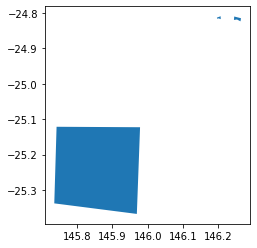

In [20]:
df_poly.plot()

### The `GeoWombat` `extract` function only uses `NumPy` arrays, which release the GIL. Therefore, extract using a threaded pool of workers.

In [ ]:
%%time

with dask.config.set(num_workers=4):

    with gw.open(frac, chunks=(1, 512, 512)) as ds:    
        df = ds.gw.extract(df_point.head(100))       # <-- limit to 100 points for demonstration

print('Shape:', df.shape, '\n')
print(df.head(3))

In [ ]:
# %%time

# with dask.config.set(num_workers=4):

#     with gw.open(sr, chunks=(1, 512, 512)) as ds:    
#         df = ds.gw.extract(df_point.head(100), bands=3, band_names=['red'])

# print(df.head(3))

In [72]:
%%time

with dask.config.set(num_workers=4):

    with gw.open(sr, chunks=(1, 512, 512)) as ds:
        
        df_poly_proj = df_poly.to_crs(crs=ds.crs)
        
        df = ds.gw.extract(df_poly.head(2),       # <-- limit to 2 polygons for demonstration
                           band_names=['blue', 'green', 'red', 'nir', 'swir1', 'swir2'],    # <-- give the band a name
                           frac=0.1)              # <-- randomly sample 10% of pixels within each polygon

print(df_poly)
print('')
print(df)

     id  value                                           geometry
0  None      1  POLYGON ((146.1956413126835 -24.81334486143801...
1  None      2  POLYGON ((146.2444203516641 -24.81021523283085...
2  None      3  POLYGON ((145.7428164286956 -25.12155932012956...

     poly  point                  geometry  blue  green   red   nir  swir1  \
0       0      0  POINT (1416810 -2760590)   347    505   654  1866   1661   
1       0      1  POINT (1416060 -2760650)   297    442   595  1949   1729   
2       0      2  POINT (1416960 -2760320)   431    701   900  1995   2006   
3       0      3  POINT (1416900 -2760200)   320    483   578  2051   1510   
4       0      4  POINT (1416840 -2760380)   322    557   578  1841   1668   
..    ...    ...                       ...   ...    ...   ...   ...    ...   
181     1    244  POINT (1421100 -2761310)   409    712   963  2217   2546   
182     1    245  POINT (1422120 -2761370)   493    742   951  2070   2877   
183     1    246  POINT (1421520 

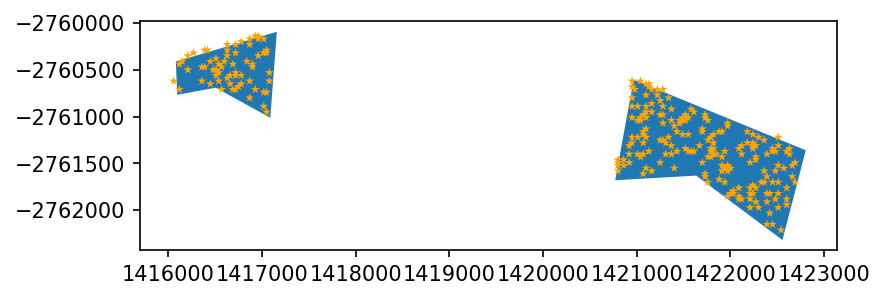

In [41]:
fig, ax = plt.subplots(dpi=150)

ax = df_poly_proj.head(2).plot(ax=ax)
ax = df.plot(c='orange', marker='*', markersize=20, edgecolor='none', ax=ax)

### is the same as ...

In [ ]:
# %%time

# with gw.open(frac, chunks=(1, 512, 512)) as ds:    
#     df = ds.gw.extract(vector, scheduler='threads', num_workers=4)

# print(df.head(3))

### or ...

In [ ]:
# %%time

# cluster = LocalCluster(n_workers=1,
#                        threads_per_worker=4,
#                        scheduler_port=0,
#                        processes=False)

# client = Client(cluster)

# with joblib.parallel_backend('dask'):

#     with gw.open(frac, chunks=(1, 2048, 2048)) as ds:    
#         df = ds.gw.extract(vector)

# print(df.head(3))

# client.close()
# cluster.close()

---
## Plotting
---

In [42]:
xcoord = 1245107
ycoord = -2705330

time_slice = slice('1988-01-01', '1999-01-01')

---

### Slice a Dataset by time

In [47]:
with gw.open(fn_list[:10], 
             xarray_return='dataset', 
             band_names=['non-green', 'green', 'bare', 'error'], 
             dates=datetime_series[:10],
             chunks=(1, 2048, 2048)) as ds:
    
    print(ds['bands'].loc['1988':'1989'])

<xarray.DataArray 'bands' (date: 8, band: 4, y: 85092, x: 63186)>
dask.array<getitem, shape=(8, 4, 85092, 63186), dtype=uint8, chunksize=(1, 1, 2048, 2048), chunktype=numpy.ndarray>
Coordinates:
  * date     (date) datetime64[ns] 1988-02-01 1988-05-01 ... 1989-11-01
  * band     (band) <U9 'non-green' 'green' 'bare' 'error'
  * y        (y) float64 -8.554e+05 -8.555e+05 ... -3.408e+06 -3.408e+06
  * x        (x) float64 4.042e+05 4.042e+05 4.043e+05 ... 2.3e+06 2.3e+06


### Get data at a x,y location

In [48]:
with gw.open(fn_list[:10], 
             xarray_return='dataset', 
             band_names=['non-green', 'green', 'bare', 'error'], 
             dates=datetime_series[:10],
             chunks=(1, 2048, 2048)) as ds:
    
    fractional = ds['bands'].sel(x=xcoord, y=ycoord, method='nearest')

print(fractional)

<xarray.DataArray 'bands' (date: 10, band: 4)>
dask.array<getitem, shape=(10, 4), dtype=uint8, chunksize=(1, 1), chunktype=numpy.ndarray>
Coordinates:
  * date     (date) datetime64[ns] 1988-02-01 1988-05-01 ... 1990-05-01
  * band     (band) <U9 'non-green' 'green' 'bare' 'error'
    y        float64 -2.705e+06
    x        float64 1.245e+06


### Get a single band

In [49]:
with gw.open(fn_list[:10], 
             xarray_return='dataset', 
             band_names=['non-green', 'green', 'bare', 'error'], 
             dates=datetime_series[:10],
             chunks=(1, 2048, 2048)) as ds:
    
    green_frac = ds['bands'].sel(x=xcoord, y=ycoord, method='nearest').sel(band='green')

print(green_frac)

<xarray.DataArray 'bands' (date: 10)>
dask.array<getitem, shape=(10,), dtype=uint8, chunksize=(1,), chunktype=numpy.ndarray>
Coordinates:
  * date     (date) datetime64[ns] 1988-02-01 1988-05-01 ... 1990-05-01
    band     <U9 'green'
    y        float64 -2.705e+06
    x        float64 1.245e+06


### Get a single band and plot a time slice

/usr/local/lib/python3.6/dist-packages/pandas-0.25.1-py3.6-linux-x86_64.egg/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


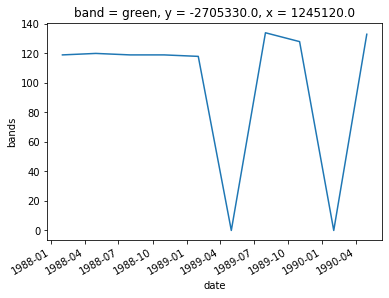

In [50]:
with gw.open(fn_list[:10], 
             xarray_return='dataset', 
             band_names=['non-green', 'green', 'bare', 'error'], 
             dates=datetime_series[:10],
             chunks=(1, 2048, 2048)) as ds:
    
    green_frac = ds['bands'].sel(x=xcoord, y=ycoord, method='nearest').sel(band='green')

green_frac.sel(date=time_slice).plot()

### Get a single band and plot a gap-filled time slice

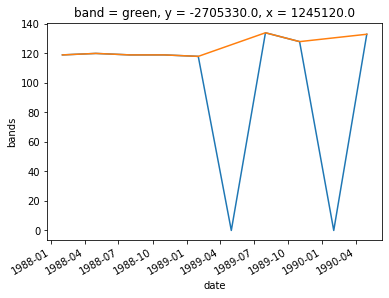

In [51]:
with gw.open(fn_list[:10], 
             xarray_return='dataset', 
             band_names=['non-green', 'green', 'bare', 'error'], 
             dates=datetime_series[:10],
             chunks=(1, 2048, 2048)) as ds:
    
    green_frac = ds['bands'].sel(x=xcoord, y=ycoord, method='nearest').sel(band='green')

green_frac.sel(date=time_slice).plot()

green_frac.where(green_frac != 0).chunk(chunks=1e9).interpolate_na(dim='date', method='linear').plot()

### Subset an image by the upper left coordinate

<IPython.core.display.Javascript object>


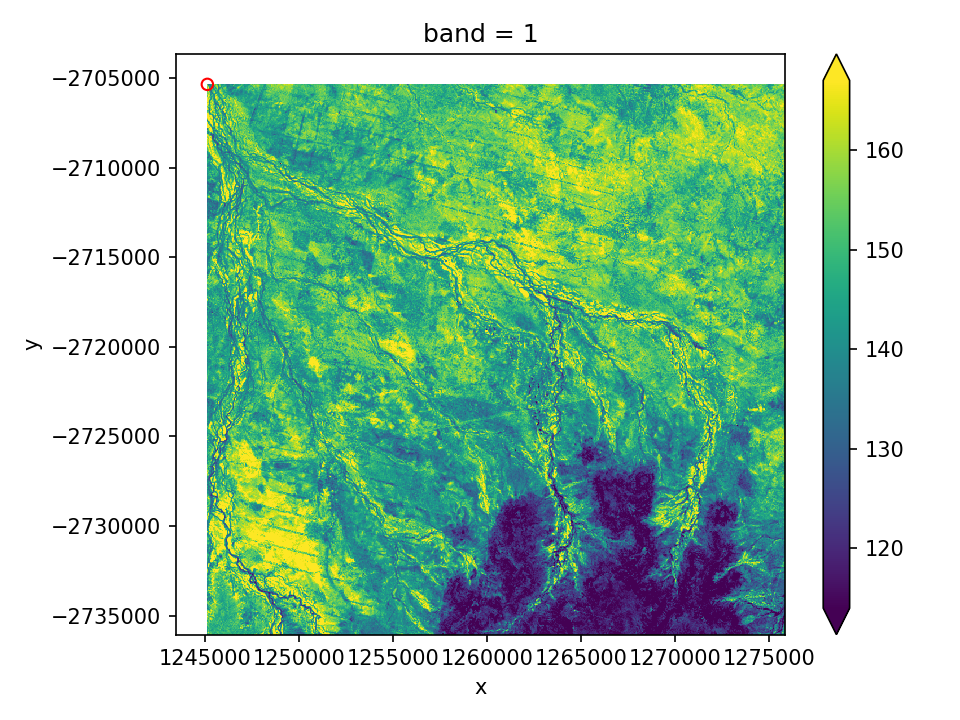

In [52]:
%matplotlib notebook

fig, ax = plt.subplots(dpi=150)

# Open as an `Xarray.DataArray` and write data to a new file
with gw.open(frac, chunks=(1, 2048, 2048)) as ds:

    dss = ds.gw.subset(left=xcoord, 
                       top=ycoord, 
                       rows=1024, 
                       cols=1024, 
                       chunksize=(1, 512, 512))
    
    dss[0].plot.imshow(robust=True, ax=ax)
    
ax.scatter(xcoord, ycoord, c='none', edgecolor='red', s=30)        

plt.tight_layout()

### Subset by the center coordinate

<IPython.core.display.Javascript object>


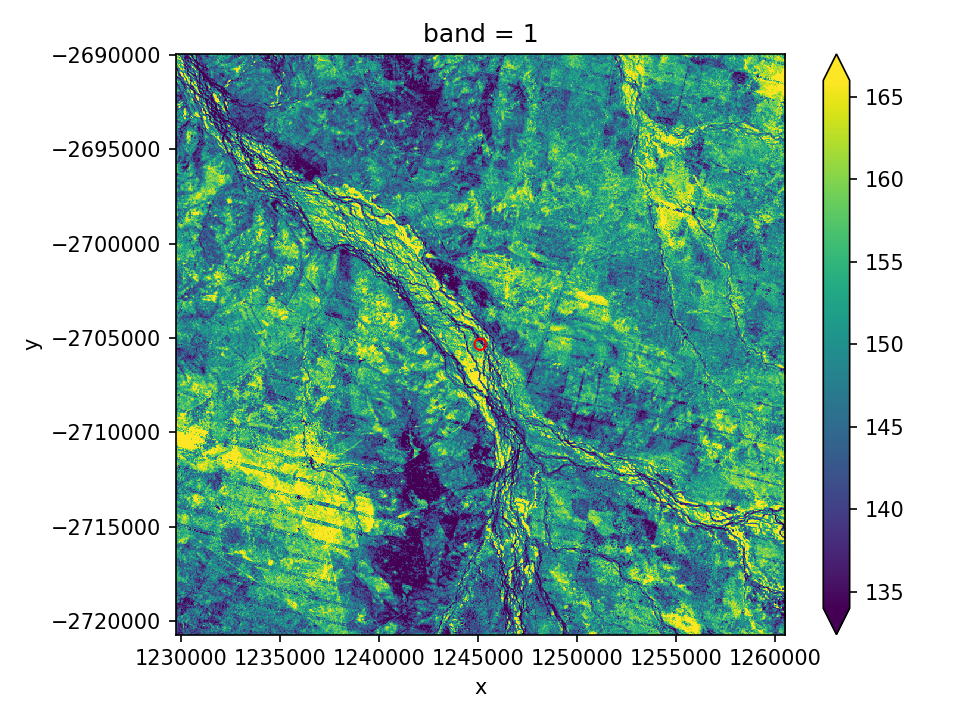

In [53]:
%matplotlib notebook

fig, ax = plt.subplots(dpi=150)

# Open as an `Xarray.DataArray` and write data to a new file
with gw.open(frac, chunks=(1, 2048, 2048)) as ds:

    dss = ds.gw.subset(left=xcoord, 
                       top=ycoord, 
                       rows=1024, 
                       cols=1024, 
                       center=True,
                       chunksize=(1, 512, 512))
    
    dss[0].plot.imshow(robust=True, ax=ax)
    
ax.scatter(xcoord, ycoord, c='none', edgecolor='red', s=30)        

plt.tight_layout()

### Mask the corners

<IPython.core.display.Javascript object>


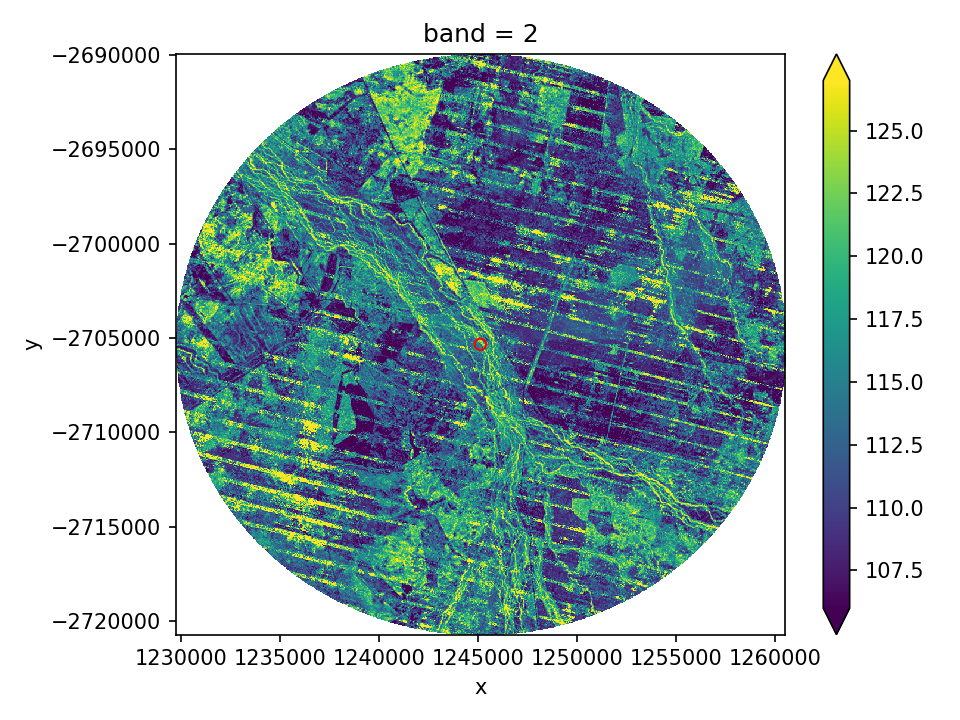

In [54]:
%matplotlib notebook

fig, ax = plt.subplots(dpi=150)

with gw.open(frac, chunks=(1, 2048, 2048)) as ds:

    dss = ds.gw.subset(left=xcoord, 
                       top=ycoord, 
                       rows=1024, 
                       cols=1024, 
                       center=True, 
                       mask_corners=True,
                       chunksize=(1, 512, 512))

    dss[1].plot.imshow(robust=True, ax=ax)
    
ax.scatter(xcoord, ycoord, c='none', edgecolor='red', s=30)    

plt.tight_layout()

### Plot multiple bands with `Datasets`

<IPython.core.display.Javascript object>


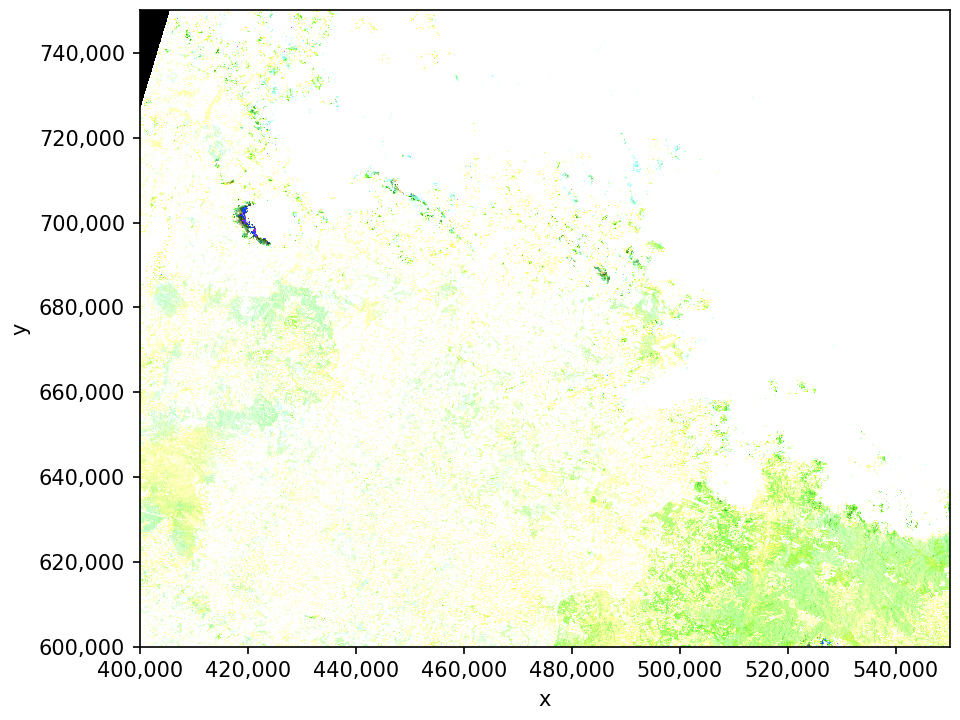

In [57]:
with gw.open(nc_file,
             chunks={'wavelength': 1,
                     'y': 2000,
                     'x': 2000}) as ds:
    
    ds.gw.show(['red', 'green', 'blue'])

### Adjust the contrast

<IPython.core.display.Javascript object>


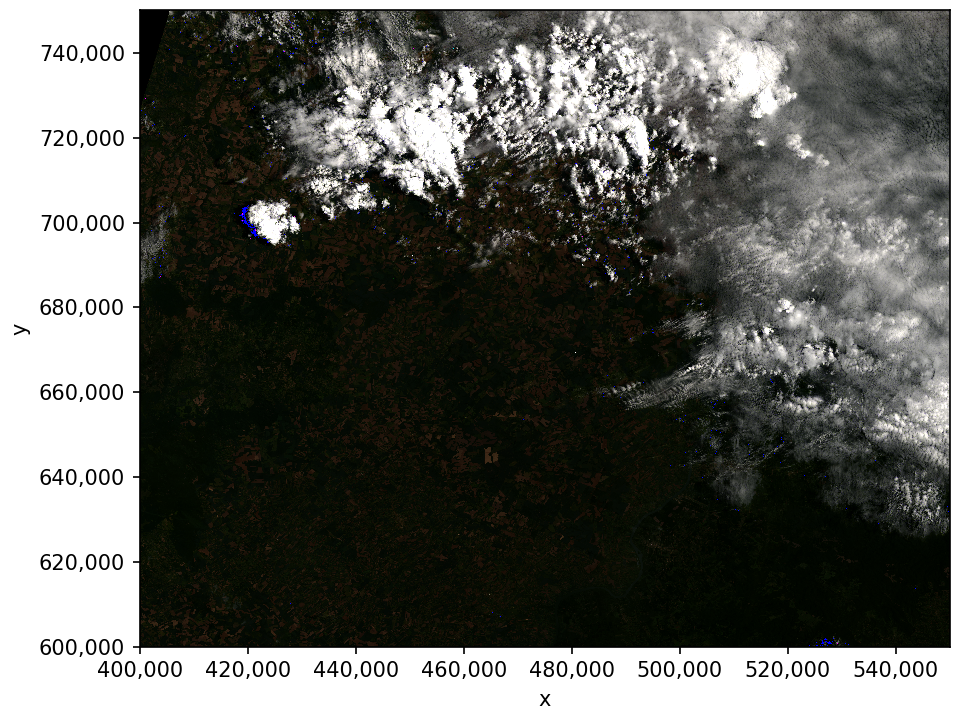

In [58]:
with gw.open(nc_file,
             chunks={'wavelength': 1,
                     'y': 2000,
                     'x': 2000}) as ds:
    
    ds.gw.show(['red', 'green', 'blue'],
               robust=True)

### Mask clouds

<IPython.core.display.Javascript object>


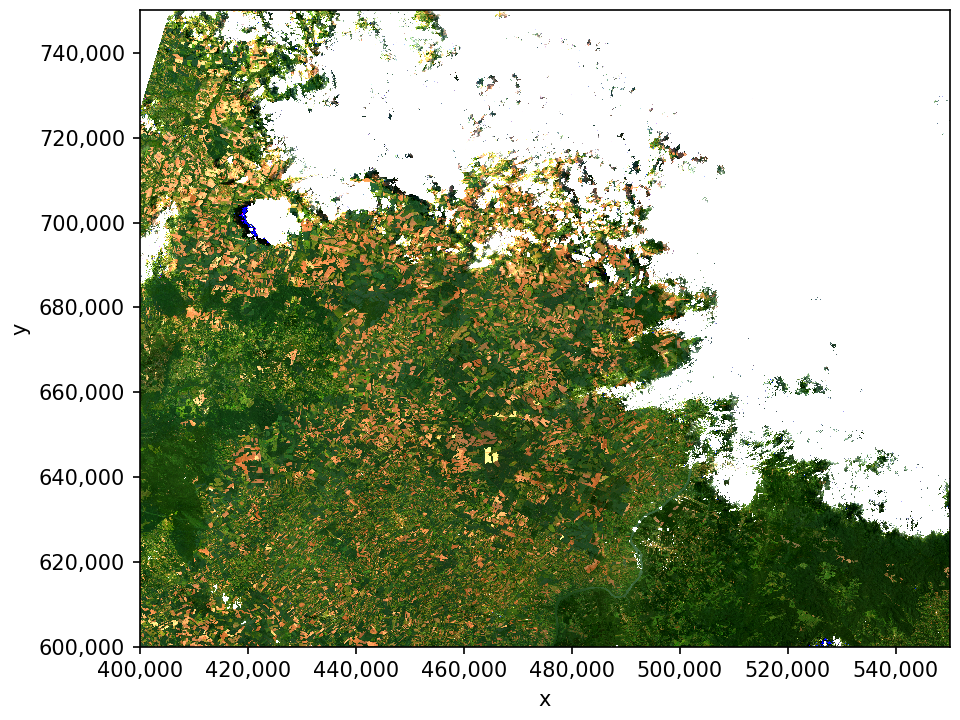

In [59]:
with gw.open(nc_file,
             chunks={'wavelength': 1,
                     'y': 2000,
                     'x': 2000}) as ds:
    
    ds.gw.show(['red', 'green', 'blue'],
               mask=True,
               robust=True)

---

In [ ]:
# hv.extension('bokeh', width=80)

In [ ]:
# def combine_bands(r, g, b, nodata=0):
    
#     xs, ys = r['x'], r['y']
#     r, g, b = [dsh.utils.orient_array(img) for img in (r, g, b)]
    
#     return hv.RGB((xs, ys[::-1], r, g, b), vdims=list('RGB'), rtol=100.0)

In [ ]:
# # %matplotlib notebook

# # fig, ax = plt.subplots(dpi=150)

# tiles = get_provider(Vendors.CARTODBPOSITRON)

# with gw.open(filename, chunks=(1, 512, 512)) as ds:

#     dss = ds.gw.subset_by_coords(xcoord, 
#                                  ycoord, 
#                                  rows=1024, 
#                                  cols=1024, 
#                                  center=True, 
#                                  mask_corners=True,
#                                  chunksize=(1, 512, 512))

#     dssl = dss.load()
    
#     rgb = combine_bands(dssl[0], dssl[1], dssl[2], nodata=1)
    
# #     p = * rgb  # regrid(rgb).relabel("True Color (R=Red, G=Green, B=Blue)")
    
# bokeh_show(rgb, notebook_handle=True)

In [ ]:
# %matplotlib notebook

# fig, ax = plt.subplots(dpi=120)

# green = dataset['bands'].sel(time=time_slice, 
#                              component='green').sel(x=xcoord, 
#                                                     y=ycoord, 
#                                                     method='nearest')

# green.where(green != 0).chunk(chunks=1e9).interpolate_na(dim='time', method='linear').plot(c='green', 
#                                                                                            label='Green', 
#                                                                                            ax=ax)

# bare = dataset['bands'].sel(time=time_slice, 
#                          component='bare').sel(x=xcoord, 
#                                                 y=ycoord, 
#                                                method='nearest')

# bare.where(bare != 0).chunk(chunks=1e9).interpolate_na(dim='time', method='linear').plot(c='grey',
#                                                                                          label='Bare',
#                                                                                          ax=ax)

# nongreen = dataset['bands'].sel(time=time_slice, 
#                          component='non-green').sel(x=xcoord, 
#                                                     y=ycoord, 
#                                                     method='nearest')

# nongreen.where(nongreen != 0).chunk(chunks=1e9).interpolate_na(dim='time', method='linear').plot(c='orange', 
#                                                                                                  label='Non-green',
#                                                                                                  ax=ax)

# plt.legend()

---
## <font color='green'>Writing data to file</font>
---

In [60]:
n_jobs = 4

In [61]:
cluster = LocalCluster(n_workers=n_jobs,
                       threads_per_worker=1,
                       scheduler_port=0,
                       processes=False)

client = Client(cluster)

# cluster = PBSCluster(cores=2,
#                      memory='20GB',
#                      queue='juptwkq',
#                      walltime='00:01:30')

# cluster.scale(4)

# client = Client(cluster)

In [62]:
client

<Client: 'inproc://10.0.214.62/50107/1' processes=4 threads=4, memory=51.54 GB>

### Subset `Xarray` data to test processes

In [65]:
with joblib.parallel_backend('dask'):

    # Open as an `Xarray.DataArray` and write data to a new file
    with gw.open(frac, chunks=(1, 512, 512)) as ds:

        dss = ds.gw.subset(left=xcoord, 
                           top=ycoord, 
                           rows=512, 
                           cols=512, 
                           center=True, 
                           chunksize=(1, 256, 256))
      
        dss = dss[1]
        
        print(dss)

<xarray.DataArray (y: 512, x: 512)>
dask.array<getitem, shape=(512, 512), dtype=uint8, chunksize=(256, 256), chunktype=numpy.ndarray>
Coordinates:
    band     int64 2
  * y        (y) float64 -2.698e+06 -2.698e+06 ... -2.713e+06 -2.713e+06
  * x        (x) float64 1.237e+06 1.237e+06 1.238e+06 ... 1.253e+06 1.253e+06
Attributes:
    transform:      (30.0, 0.0, 1237427.0, 0.0, -30.0, -2697650.0)
    crs:            +proj=aea +lat_1=-18 +lat_2=-36 +lat_0=0 +lon_0=132 +x_0=...
    res:            (30.0, 30.0)
    is_tiled:       1
    nodatavals:     (0.0, 0.0, 0.0, 0.0)
    scales:         (1.0, 1.0, 1.0, 1.0)
    offsets:        (0.0, 0.0, 0.0, 0.0)
    AREA_OR_POINT:  Area


### Write data to file

In [66]:
with joblib.parallel_backend('dask'):

    # Open as an `Xarray.DataArray` and write data to a new file
    with gw.open(frac, chunks=(1, 512, 512)) as ds:

        dss = ds.gw.subset(left=xcoord, 
                           top=ycoord, 
                           rows=512, 
                           cols=512, 
                           center=True, 
                           chunksize=(1, 256, 256))
      
        dss = dss[1]
        
        dss.gw.to_raster('/scratch/rsc4/graesser/datasets/woody_indicators/validation/test.tif',
                         n_jobs=n_jobs,
                         verbose=1,
                         gdal_cache=512,
                         overwrite=True,
                         row_chunks=256,
                         col_chunks=256,
                         tiled=True,
                         blockxsize=256,
                         blockysize=256,
                         compress='lzw')

Creating and writing to the file ...


100%|██████████| 4/4 [00:00<00:00, 17.54it/s]

Finished writing


In [ ]:
# with joblib.parallel_backend('dask'):

#     # Open as an `Xarray.DataArray` and write data to a new file
#     with gw.open(frac, chunks=(1, 512, 512)) as ds:
        
#         dss = ds[1]
        
#         dss.gw.to_raster('/scratch/rsc4/graesser/datasets/woody_indicators/validation/test.tif',
#                          n_jobs=n_jobs,
#                          verbose=1,
#                          gdal_cache=512,
#                          overwrite=True,
#                          row_chunks=512,
#                          col_chunks=512,
#                          pool_chunksize=50,
#                          tiled=True,
#                          dtype='uint8',
#                          blockxsize=512,
#                          blockysize=512,
#                          compress='lzw')

### Shutdown the client

In [67]:
client.close()
cluster.close()

client = None
cluster = None

---
## <font color='green'>Machine learning</font>
---

In [69]:
from geowombat.model import Model

### Fit a classifier

In [73]:
df['response'] = np.random.randint(0, high=4, size=df.shape[0])
df['weights'] = np.random.randn(df.shape[0])

In [77]:
df.head(3)

poly  point                  geometry  blue  green  red   nir  swir1  \
0     0      0  POINT (1416810 -2760590)   347    505  654  1866   1661   
1     0      1  POINT (1416060 -2760650)   297    442  595  1949   1729   
2     0      2  POINT (1416960 -2760320)   431    701  900  1995   2006   

   swir2  response   weights  
0    955         3 -0.150704  
1   1084         1 -1.777085  
2   1385         3 -0.673833

In [80]:
clf = Model(name='lightgbm', use_dask=True, n_jobs=4)
clf.fit(df, x=['red', 'nir'], y='response', sample_weight='weights')

In [ ]:
# clf.to_file('lgm.model')
# clf.from_file('lgm.model')

### Predict on an image subset

In [ ]:
with gw.open(sr, chunks=(1, 512, 512)) as ds:
    
    dss = ds.gw.subset(left=xcoord, 
                       top=ycoord, 
                       rows=512, 
                       cols=512, 
                       center=True, 
                       chunksize=(1, 256, 256))
    
    dss.gw.predict(clf)

---
## <font color='green'>Calculate the long-term mean green</font>
---

In [ ]:
# green_mean = dataset['bands'].sel(component='green').loc['1988':'1989'].mean(axis=0)

In [ ]:
# green_mean_ds = xr.Dataset({'bands': (['y', 'x'], green_mean.data)},
#                            coords={'y': ('y', dataset.y),
#                                    'x': ('x', dataset.x)}, 
#                            attrs=dataset.attrs)

In [ ]:
# green_mean_ds

#### Write the mean to file

xarray.open_rasterio + dask.array.stack + temporal mean

In [ ]:
%%time
green_mean_ds.io.to_raster('green_mean.tif', 
                           attribute='bands', 
                           n_jobs=32, 
                           verbose=1,
                           gdal_cache=512,
                           tiled=True, 
                           blockxsize=2048, 
                           blockysize=2048, 
                           compress='lzw')